In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, pystan as ps, matplotlib.pyplot as plt
from tqdm import trange
import scipy
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="brain_DL.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6b2d0b798f12e3033751722baf72ffd NOW.


In [3]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "brain_data/data_column"+str(i+1)
    X[i] = loadtxt("brain_data/data_column1", comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

In [4]:
N = 21 
m = np.shape(X)[1]
p = 10
a = 1/m
data = dict(N=N, p=p, m=m, a=a, X=X[:N]);

In [5]:
control = dict(max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, iter=1_00, init="random")
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


475.32 minutes to run
Inference for Stan model: anon_model_d6b2d0b798f12e3033751722baf72ffd.
10 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=500.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]         -1.82    0.48   1.14  -3.59  -2.62  -1.87  -1.29   0.98      6   5.23
Z[2,1]         -1.63    0.98   2.23  -4.98  -3.45  -2.23   0.71   1.66      5  10.75
Z[3,1]          0.64    0.94   2.16  -4.84  -0.28   1.56   2.21   2.96      5   8.49
Z[4,1]           1.3    0.98   2.25  -3.18  -1.03   2.22    3.1   4.09      5   8.44
Z[5,1]          1.16    0.77   1.77  -1.97  -0.29    1.4   2.45   4.08      5   6.74
Z[6,1]         -1.91    0.71   1.63  -3.88  -3.07  -2.49  -1.23   2.29      5   7.09
Z[7,1]          1.52    1.18   2.68  -3.89   0.22   1.24   3.06   6.97      5  12.13
Z[8,1]          0.99    1.01   2.28  -1.69  -0.89   0.09    3.3   5.02      5  13.35
Z[9,1]          1.53    1.04 

In [6]:
n_samples = np.shape(trace['u'])[0]

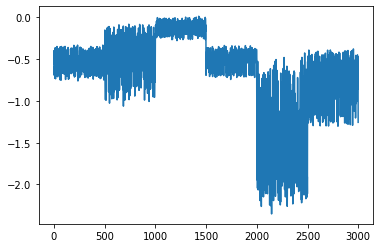

In [6]:
i, j = 1, 3
n = 20

π = trace['Z'][:,i,j] + \
         [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
          for idx in range(n_samples)]
plt.plot(π);

In [7]:
π_chain = np.zeros((n_samples, N,m,m))
for n in range(N) :
    for i in range(m) :
        for j in range(m) :
            π_chain[:,n,i,j] = trace['Z'][:,i,j] + \
                          [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
                           for idx in range(np.shape(trace['u'])[0])]

In [8]:
ll = np.zeros(n_samples)
probs = 1/(1+np.exp(-π_chain))
for itr in range(len(ll)) :
    ll[itr] = np.sum(X*np.log(probs[itr]) + (1-X)*np.log(1-probs[itr]))

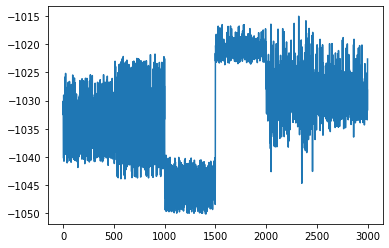

In [9]:
plt.plot(ll)

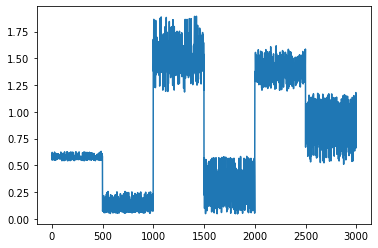

In [12]:
i = 2
plt.plot([scipy.linalg.norm(trace['u'][itr,i,:]) for itr in range(n_samples)])

In [14]:
np.shape(trace['u'])

(3000, 10, 4)

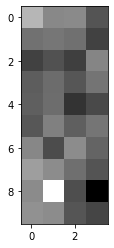

In [20]:
plt.imshow(np.mean(trace['u'],0), cmap="gray")

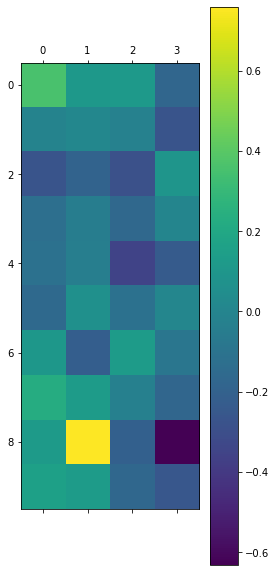

In [22]:
plt.matshow(np.mean(trace['u'],0))
plt.colorbar()

In [26]:
np.shape(trace['u'])

(3000, 10, 4)

In [31]:
np.max(np.linalg.svd(trace['u'][0])[1])

2.3828236660607733

In [33]:
U_normalised = [trace['u'][itr]/np.max(np.linalg.svd(trace['u'][itr])[1]) for itr in range(n_samples)]